# Feature selection and then classification with [Qiskit](https://qiskit.org/documentation/stable/0.19/index.html)

This notebook has two parts
- __Feature selection__ can be cast as a Quadratic Unconstrained Binary Optimization (__QUBO__) problem [[arXiv:2104.04049](https://arxiv.org/abs/2104.04049), [arXiv:2203.13261](https://arxiv.org/abs/2203.13261)] that can be solved with [Qiskit Optimization](https://qiskit.org/ecosystem/optimization/). 
- __Classification__ is a Machine learning (__ML__) problem that can be completed with [Qiskit Machine Learning](https://qiskit.org/ecosystem/machine-learning/)



Here, we have taken [sklearn.datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)
and given several methods for both feature selection and classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings


from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier


'''datasets:'''
from sklearn.datasets import (load_iris, load_wine, load_breast_cancer)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


## Data loading ...

In [2]:
dataset = load_wine()                         # choose one of the above datasets
X, y = dataset.data, dataset.target


X = MinMaxScaler().fit_transform(X)           # this will put all the feature (X) values in the interval [0,1]


num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)


X[:3,:], y[:3]                                # first 3 examples

number of examples =  178
number of features =  13


(array([[0.84210526, 0.1916996 , 0.57219251, 0.25773196, 0.61956522,
         0.62758621, 0.57383966, 0.28301887, 0.59305994, 0.37201365,
         0.45528455, 0.97069597, 0.56134094],
        [0.57105263, 0.2055336 , 0.4171123 , 0.03092784, 0.32608696,
         0.57586207, 0.51054852, 0.24528302, 0.27444795, 0.26450512,
         0.46341463, 0.78021978, 0.55064194],
        [0.56052632, 0.3201581 , 0.70053476, 0.41237113, 0.33695652,
         0.62758621, 0.61181435, 0.32075472, 0.75709779, 0.37542662,
         0.44715447, 0.6959707 , 0.64693295]]),
 array([0, 0, 0]))

## train test split

In [3]:
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train_.shape, X_test_.shape)

(124, 13) (54, 13)


$ $

$ $

# Feature Selection

In [4]:
feature_names = dataset.feature_names
print(f'feature_names = {feature_names} \n') 


feature_names = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'] 



In [5]:
k = 4
print(f'number of features to be selected = {k}\n')

number of features to be selected = 4



## (A) Feature selection with a quantum algorithm

For feature selection, we are following the approach given in [arXiv:2104.04049](https://arxiv.org/abs/2104.04049) (see also, [arXiv:2203.13261](https://arxiv.org/abs/2203.13261)) where one can cast it as a 

__quadratic program (QP)__:
$\min_{\bf{v}} \bf{v}\ Q\ \bf{v}$ where the binary vector $\bf{v}$ carries decision variable $v_i$ for each feature $i$. 
$v_i = 1$ and $0$ mean $i$th feature is and is not selected, respectively.
To select $k$ number of features, we put the constraint $\sum_i v_i=k$.

$Q$ is an upper triangular matrix.
- The __off-diagonal__ entry $Q_{ij}$, $i<j$, is proportional to the Pearson correlation coefficient between features $x_i$ and $x_j$. A higher value of such a correlation is a signature of __redundancy__ that we want to minimize.

- The __negative__ of __diagonal__ entry $-Q_{ii}$ is proportional to the Pearson correlation coefficient between features $x_i$ and target $y$. A higher value of such a correlation is a signature of __relevancy__ that we want to maximize.



The QP can be turned into a Quadratic Unconstrained Binary Optimization (QUBO) problem that can be covered into an Ising Hamiltonian whose ground state represents the optimal solution. One can use different quantum algorithms to find a state close to the ground state as shown below.  


### (A1a) Q matrix

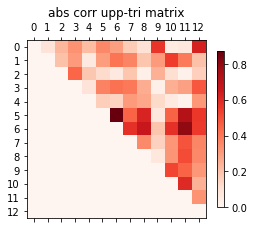

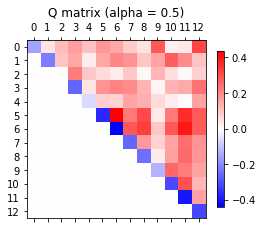

In [6]:
# Pearson correlation coefficient between features x_i and x_j
xx_pcc = np.corrcoef(X_train_.T)
xx_pcc = np.abs(np.triu(xx_pcc, 1)) 


plt.matshow(xx_pcc, cmap='Reds')
plt.xticks(np.arange(num_features))
plt.yticks(np.arange(num_features))
cb = plt.colorbar(shrink=0.7)
plt.title('abs corr upp-tri matrix') 
plt.show()


# Pearson correlation coefficient between feature x_i and target y
xy_pcc = [np.abs(np.corrcoef(X_train_[:,l], y_train)[0,1]) for l in range(num_features)]


# alpha is the weight attached to the off-diagonal terms,  0 <= alpha <=1
# 1- alpha is the weight attached to the diagonal terms of Q
alpha = 0.5

Q = alpha*xx_pcc - (1-alpha)*np.diag(xy_pcc)


def plot_Q_matrix():
    plt.matshow(Q, cmap='bwr')
    plt.xticks(np.arange(num_features))
    plt.yticks(np.arange(num_features))
    cb = plt.colorbar(shrink=0.7)
    plt.title(f'Q matrix (alpha = {alpha})') 
    plt.show()

plot_Q_matrix()

In [7]:
from qiskit_optimization import QuadraticProgram                         #!pip install qiskit[optimization]

from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver, QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Sampler
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA, COBYLA

### (A1b) Quadratic Program using the Q matrix

In [8]:
qp = QuadraticProgram()

for i in range(num_features):
    qp.binary_var(f'v{i}')

    
linear = [Q[i,i] for i in range(num_features)]

quadratic = {}
for i in range(num_features):
    for j in range(i+1, num_features):
        quadratic[(f'v{i}', f'v{j}')] = Q[i,j]
        

qp.minimize(linear=linear, quadratic=quadratic)


linear_const = {f'v{i}':1 for i in range(num_features)}        # the constraint to select k number of features
qp.linear_constraint(linear=linear_const, sense="==", rhs=k, name="lin_const")
qp

<QuadraticProgram: minimize 0.043633758272574194*v0*v1 + 0.023714908751248903*..., 13 variables, 1 constraints, ''>

### (A2a) Feature selection by solving Quadratic Program with the exact classical eigensolver

The class [__MinimumEigenOptimizer__](https://qiskit.org/ecosystem/optimization/stubs/qiskit_optimization.algorithms.MinimumEigenOptimizer.html) provides a wrapper for minimum eigen solvers from Qiskit to be used within the optimization module. It assumes a problem consisting only of binary or integer variables as well as linear equality constraints thereof. It converts such a problem into a QUBO problem by expanding integer variables into binary variables and by adding the linear equality constraints as weighted penalty terms to the objective function. The resulting QUBO is then translated into an Ising Hamiltonian whose minimal eigen vector and corresponding eigenstate correspond to the optimal solution of the original optimization problem. The provided minimum eigen solver is then used to approximate the ground state of the Hamiltonian to find a good solution for the optimization problem.


In [9]:
%%time

exact = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())
print()

objective function value: -0.44192253595886444
variable values: v0=1.0, v1=0.0, v2=0.0, v3=0.0, v4=1.0, v5=0.0, v6=0.0, v7=0.0, v8=0.0, v9=0.0, v10=1.0, v11=1.0, v12=0.0
status: SUCCESS

CPU times: user 376 ms, sys: 0 ns, total: 376 ms
Wall time: 374 ms


### (A2b) Feature selection by solving Quadratic Program with [VQE](https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.SamplingVQE.html)

VQE is a hybrid quantum-classical algorithm that uses a variational technique to find the minimum eigenvalue of a given diagonal Hamiltonian.

In [10]:
%%time
ansatz = TwoLocal(num_features, "ry", "cz", reps=3, entanglement="linear")           # construct ansatz for VQE
vqe = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=COBYLA(maxiter=10))    # construct VQE


meo_vqe = MinimumEigenOptimizer(min_eigen_solver=vqe)                                # run VQE
result_vqe = meo_vqe.solve(qp)


print(result_vqe.prettyprint())
print()

objective function value: -0.44192253595886444
variable values: v0=1.0, v1=0.0, v2=0.0, v3=0.0, v4=1.0, v5=0.0, v6=0.0, v7=0.0, v8=0.0, v9=0.0, v10=1.0, v11=1.0, v12=0.0
status: SUCCESS

CPU times: user 11.4 s, sys: 124 ms, total: 11.6 s
Wall time: 11.5 s


### (A2c) Feature selection by solving Quadratic Program with [QAOA](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html)

The QAOA implementation directly extends VQE and inherits VQE’s optimization structure.

In [11]:
%%time
qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=10), reps=3)      # construct QAOA


meo_qaoa = MinimumEigenOptimizer(min_eigen_solver=qaoa)                   # run QAOA
result_qaoa = meo_qaoa.solve(qp)


print(result_qaoa.prettyprint())
print()

objective function value: -0.44192253595886444
variable values: v0=1.0, v1=0.0, v2=0.0, v3=0.0, v4=1.0, v5=0.0, v6=0.0, v7=0.0, v8=0.0, v9=0.0, v10=1.0, v11=1.0, v12=0.0
status: SUCCESS

CPU times: user 19.6 s, sys: 120 ms, total: 19.7 s
Wall time: 19.7 s


### (A2d) Feature selection by solving Quadratic Program with a classical greedy algorithm

Here, the initial solution carries k ones and the rest zeros. A new solution is a random permutation of the last accepted solution. We accept the new solution if and only if the cost (energy) decreases. Hence, it is a classical greedy algorithm.

inital sol = [1 1 1 1 0 0 0 0 0 0 0 0 0]
initial Emin = 0.133

l =     0   Emin = -0.228   sol = [0 1 0 0 1 0 1 0 0 0 0 1 0]
l =     1   Emin = -0.288   sol = [0 0 0 1 0 0 0 1 1 1 0 0 0]
l =     3   Emin = -0.3   sol = [0 1 0 1 0 0 0 0 1 1 0 0 0]
l =     5   Emin = -0.305   sol = [0 0 0 1 1 0 1 0 0 0 0 1 0]
l =    29   Emin = -0.312   sol = [0 1 0 1 0 1 0 0 0 1 0 0 0]
l =    56   Emin = -0.318   sol = [1 0 0 1 1 0 0 0 0 0 1 0 0]
l =   130   Emin = -0.328   sol = [0 0 0 0 1 0 0 0 0 0 1 1 1]
l =   209   Emin = -0.401   sol = [0 0 0 1 1 0 0 0 0 0 1 1 0]
l =   309   Emin = -0.442   sol = [1 0 0 0 1 0 0 0 0 0 1 1 0]

selected_feature_positions = [ 0  4 10 11]



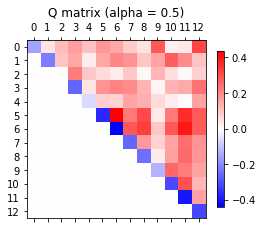

In [12]:
sol = np.append(np.ones(k, dtype=int), np.zeros(num_features-k, dtype=int))
Emin = np.linalg.multi_dot([sol, Q , sol])

print(f'inital sol = {sol}')
print(f'initial Emin = {round(Emin,3)}\n')
       
for l in range(10000):
    s = np.random.permutation(sol)
    E = np.linalg.multi_dot([s, Q , s])
    if E < Emin:
        sol, Emin = s, E
        print(f'l = {l:5d}   Emin = {round(Emin,3)}   sol = {sol}')
        
        

pos = np.where(sol==1)[0]
print()
print(f'selected_feature_positions = {pos}\n')

plot_Q_matrix()


$ $

## (B) Feature selection with sklearn based on mutual_info_classif

In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif


f = SelectKBest(mutual_info_classif, k=4).fit(X_train_, y_train)
selected_features = f.get_feature_names_out(feature_names)
selected_features_pos = [np.where(np.array(feature_names) == sf)[0][0] for sf in selected_features]

print(f'selected_features = {selected_features}\n')
print(f'selected_feature_positions = {selected_features_pos}\n')


selected_features = ['flavanoids' 'color_intensity' 'hue' 'od280/od315_of_diluted_wines']

selected_feature_positions = [6, 9, 10, 11]



# After feature selection train and test sets

In [14]:
print(f'selected_feature_positions = {pos}\n')
print(f'selected_features = {np.array(feature_names)[pos]}\n')

X_train, X_test = X_train_[:,pos], X_test_[:,pos]

   
print(f"number selected of features = k = {k}:", k==X_train.shape[1])

selected_feature_positions = [ 0  4 10 11]

selected_features = ['alcohol' 'magnesium' 'hue' 'od280/od315_of_diluted_wines']

number selected of features = k = 4: True


$ $

# Classification with Quantum Machine Learning

The following part is based on [the Qiskit Machine Learning tutorial](https://qiskit.org/ecosystem/machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html)


## (1) Feature Map (FM): angle encoding

In [15]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap


fm = ZZFeatureMap(feature_dimension=k, reps=1)                  
fm.decompose().draw() 


┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«                                                    »
«q_0: ──────────────────────────────────■─────────■──»
«                                       │         │  »
«q_1: ──────────────────────────────────┼────■────┼──»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐  │  »
«q_2: ┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├──┼──»
«     └──────────────────────────────┘└───┘└───┘┌─┴─┐»
«q_3: ──────────────────────────────────────────┤ X ├»
«                                               └───┘»
«                                                    »
«q_0: ───────────────────────────────────────■───────»
«                                            │       »
«q_1: ──────────────────────────────────■────┼────■──»
«     ┌──────────────────────────────┐┌─┴─┐  │    │  »
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──┼────┼──»
«     ├──────────────────────────────┤└───┘┌─┴─┐┌─┴─┐»
«q_3: ┤ P(2.0*(π - x[0])*(π - x[3])) ├─────┤ X ├┤ X ├»
«     └──────────────────────────────┘     └───┘└───┘»
«                                               »
«q_0: ──────────────────────────────────────────»
«                                               »
«q_1: ──────────────────────────────────■───────»
«                                       │       »
«q_2: ──────────────────────────────────┼────■──»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐»
«q_3: ┤ P(2.0*(π - x[1])*(π - x[3])) ├┤ X ├┤ X ├»
«     └──────────────────────────────┘└───┘└───┘»
«                                          
«q_0: ─────────────────────────────────────
«                                          
«q_1: ─────────────────────────────────────
«                                          
«q_2: ──────────────────────────────────■──
«     ┌──────────────────────────────┐┌─┴─┐
«q_3: ┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├
«     └──────────────────────────────┘└───┘

## (2) Parameterized Quantum Circuit (PQC)

In [16]:
from qiskit.circuit.library import RealAmplitudes


pqc = RealAmplitudes(num_qubits=k, reps=3)
pqc.decompose().draw()


┌──────────┐                             ┌──────────┐             »
q_0: ┤ Ry(θ[0]) ├──────────────────────■──────┤ Ry(θ[4]) ├─────────────»
     ├──────────┤                    ┌─┴─┐    ├──────────┤             »
q_1: ┤ Ry(θ[1]) ├──────────■─────────┤ X ├────┤ Ry(θ[5]) ├──────■──────»
     ├──────────┤        ┌─┴─┐    ┌──┴───┴───┐└──────────┘    ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├──■─────┤ X ├────┤ Ry(θ[6]) ├─────■──────────┤ X ├────»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘   ┌─┴─┐    ┌───┴───┴───┐»
q_3: ┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[7]) ├───────────────┤ X ├────┤ Ry(θ[11]) ├»
     └──────────┘└───┘└──────────┘               └───┘    └───────────┘»
«                  ┌──────────┐                          ┌───────────┐
«q_0: ──────■──────┤ Ry(θ[8]) ├───────────────────■──────┤ Ry(θ[12]) ├
«         ┌─┴─┐    ├──────────┤                 ┌─┴─┐    ├───────────┤
«q_1: ────┤ X ├────┤ Ry(θ[9]) ├──────■──────────┤ X ├────┤ Ry(θ[13]) ├
«     ┌───┴───┴───┐└──────────┘    ┌─┴─┐    ┌───┴───┴───┐└───────────┘
«q_2: ┤ Ry(θ[10]) ├─────■──────────┤ X ├────┤ Ry(θ[14]) ├─────────────
«     └───────────┘   ┌─┴─┐    ┌───┴───┴───┐└───────────┘             
«q_3: ────────────────┤ X ├────┤ Ry(θ[15]) ├──────────────────────────
«                     └───┘    └───────────┘

## (3) Build the model: [Variational Quantum Classifier (VQC)](https://qiskit.org/documentation/stable/0.19/stubs/qiskit.aqua.algorithms.VQC.html#qiskit.aqua.algorithms.VQC) with FM and PQC


__[Sampler](https://qiskit.org/documentation/apidoc/primitives.html) class calculates probabilities or quasi-probabilities of bitstrings from quantum circuits.__
A sampler is initialized with an empty parameter set. The sampler is used to create a JobV1, via the qiskit.primitives.Sampler.run() method, and yields a SamplerResult object, which contains probabilities or quasi-probabilities of bitstrings, plus optional metadata like error bars in the samples.


In [17]:
from qiskit.algorithms.optimizers import COBYLA

# This defines where to train our classifier: on a simulator or a real quantum computer
from qiskit.primitives import Sampler                             # here we have chosen a simulator 

from qiskit_machine_learning.algorithms.classifiers import VQC    # !pip install qiskit[machine-learning]


#------------------------------------------------------------------------------------------------

optimizer = COBYLA(maxiter=250)                 # maxiter = Maximum number of iterations (function evaluations)
sampler = Sampler()

#------------------------------------------------------------------------------------------------

from IPython.display import clear_output
objective_func_vals = []
                                    # a callback that can access the intermediate data during the optimization
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#------------------------------------------------------------------------------------------------

vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback,
)

## (4) Training VQC ...

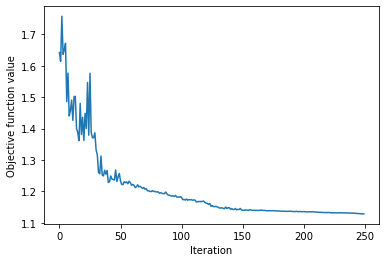

CPU times: user 3min 41s, sys: 45.6 s, total: 4min 27s
Wall time: 3min 29s


In [18]:
%%time

'''Training time increases with the number of features'''

vqc.fit(X_train, y_train)

## (5) performance evaluation of trained VQC

In [19]:
train_score = vqc.score(X_train, y_train)
test_score = vqc.score(X_test, y_test)

print(f"VQC train score: {train_score:.2f}")
print(f"VQC test score:  {test_score:.2f}")

VQC train score: 0.83
VQC test score:  0.80


$ $

$ $

# Classification with Classical Machine Learning (ML) models with [scikit-learn](https://scikit-learn.org/stable/)

In [20]:
%%time
warnings.filterwarnings('ignore')

def train_test(ML_model):
    print(15*'-', ML_model, 15*'-','\n')
    ML_model.fit(X_train, y_train)                          # fit model
    
    train_score_ML = ML_model.score(X_train, y_train)       # evaluate model
    test_score_ML = ML_model.score(X_test, y_test)
    
    print(f"ML train score: {train_score_ML:.2f}")
    print(f"ML test score:  {test_score_ML:.2f}")

    print()
    

#----------------------------------------------------------------------------------


ML_model = linear_model.LogisticRegression()              # create model instance
train_test(ML_model)


ML_model = MLPClassifier()                            
train_test(ML_model)


ML_model = svm.SVC() 
train_test(ML_model)


ML_model = RandomForestClassifier()
train_test(ML_model)


--------------- LogisticRegression() --------------- 

ML train score: 0.91
ML test score:  0.96

--------------- MLPClassifier() --------------- 

ML train score: 0.92
ML test score:  0.94

--------------- SVC() --------------- 

ML train score: 0.94
ML test score:  0.94

--------------- RandomForestClassifier() --------------- 

ML train score: 1.00
ML test score:  0.98

CPU times: user 235 ms, sys: 2.96 ms, total: 237 ms
Wall time: 255 ms


# $ $




$ $